In [14]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
#https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution


# decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# adaboost
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
# model building
from sklearn.model_selection import train_test_split, GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix

from fast_ml.model_development import train_valid_test_split
# set seed for reproducible results
RSEED = 10


In [2]:
df = pd.read_csv('data.csv')
df.shape #מספר הרשומות שיש לנו בדאטה

(12563, 9)

In [3]:
df.head() #הצגת תחילת הדאטה

,Unnamed: 0,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
0,0,B,1,3.0,1655.0,3.0,1.0,134,10800000.0
1,1,B,1,2.0,1102.0,2.0,1.0,134,4800000.0
2,2,B,0,2.0,1112.0,2.0,1.0,242,8800000.0
3,3,B,1,3.0,1450.0,3.0,3.0,335,5100000.0
4,4,B,1,2.0,1010.0,2.0,1.0,261,4100000.0


In [4]:
df.tail() # הצגת סוף הדאטה

,Unnamed: 0,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
12558,12558,B,1,3.0,1720.0,3.0,3.0,134,9897000.0
12559,12559,B,0,3.0,1275.0,3.0,2.0,276,4400000.0
12560,12560,P,1,2.0,1550.0,2.0,1.0,252,7100000.0
12561,12561,B,1,3.0,1535.0,3.0,1.0,307,7200000.0
12562,12562,B,1,1.0,400.0,1.0,1.0,435,2500000.0


In [5]:
df.isnull().sum()

Unnamed: 0         0
area_type          0
availability       0
bedrooms           0
total_sqft         0
bath               0
balcony            0
ranked             0
price in rupees    0
dtype: int64

In [105]:
df.describe() # סטטיסטיקות על המשתנים הנומרים

,Unnamed: 0,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
count,12563.000000,12563.000000,12563.000000,1.256300e+04,12563.000000,12563.000000,12563.000000,1.256300e+04
mean,6281.000000,0.798535,2.741145,1.794519e+03,2.617607,1.602165,236.386054,1.063007e+07
std,3626.770051,0.401110,1.204731,1.470231e+04,1.221164,0.804165,120.749788,1.322695e+07
min,0.000000,0.000000,1.000000,2.500000e+02,1.000000,0.000000,1.000000,8.000000e+05
25%,3140.500000,1.000000,2.000000,1.100000e+03,2.000000,1.000000,134.000000,4.950000e+06
50%,6281.000000,1.000000,3.000000,1.260000e+03,2.000000,2.000000,226.000000,7.000000e+06
75%,9421.500000,1.000000,3.000000,1.641500e+03,3.000000,2.000000,335.000000,1.150000e+07
max,12562.000000,1.000000,43.000000,1.306800e+06,40.000000,3.000000,504.000000,2.912000e+08


In [106]:
df.dtypes # סוגי משתנים שיש לנו בדאטה

Unnamed: 0           int64
area_type           object
availability         int64
bedrooms           float64
total_sqft         float64
bath               float64
balcony            float64
ranked               int64
price in rupees    float64
dtype: object

<AxesSubplot:xlabel='area_type', ylabel='count'>

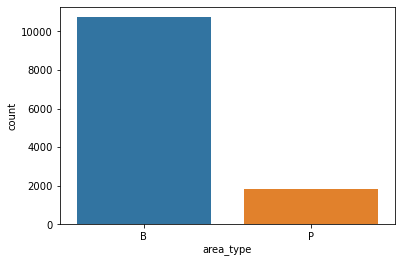

In [108]:
sns.countplot(data=df, x = 'area_type') #התפלגות הפיצר של B ו-P

# פונקציות עזר

In [75]:
# פונקציה עבור ערכים מספרים - ממיינת את כל ערכי התצפיות ומחזירה מערך עם ממוצע בין כל זוג
#https://stackoverflow.com/questions/20527563/average-of-two-consecutive-elements-in-the-list-in-python
def cal_follow_avg(values):
    sorted_numbers = sorted(values)
    res= [(sorted_numbers[i]+sorted_numbers[i+1])/2 for i in range(0, len(sorted_numbers)-1, 1)]
    return res

# פונקציה שמחשבת ג'יני
def cumpute_gini(parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gini = (weight_l*cumpute_gini_help(l_child) + weight_r*cumpute_gini_help(r_child))
        return gini

# פונקציה עזר לחישוב הג'יני
def cumpute_gini_help(y):       
        feature_value = np.unique(y) 
        gini = 0
        for val in feature_value:
            count = 0
            for y_val in y:
                if(y_val==val):
                    count+=1
            score= count/len(y) 
            gini += score**2
        return 1 - gini

# פונקציה שמגרילה מספרים ויוצרת מסד נתונים חדש מהתצפיות - עבור מימוש האדאבוסט - Adaboost
def create_new_dataset(dataset,w):
        ranges= []
        newdataset= []
        start=0;
        for weight in w:
            ranges.append((start,start+weight)) #  יוצר רשימה עם טווחים, לדוגמה: (0.5,0.7)(0,0.5)
            start+=weight
        for i in range(len(dataset)):
            n = random.random() # מגריל מספר בין 0 ל-1
            for r in ranges:
                if n<r[1] and n>=r[0]: # בודק באיזה תא המספר
                    index=ranges.index(r)
            newdataset.append(dataset[index]) #מוסיף למסד נתונים חדש את הרשימה שהוגרלה
        return np.array(newdataset)
    
def cumpute_mse(parent, left, right):
    #https://medium.com/analytics-vidhya/regression-trees-decision-tree-for-regression-machine-learning-e4d7525d8047
    weight_l = len(left) / len(parent)
    weight_r = len(right) / len(parent)
    mse = (weight_l*np.var(left) + weight_r*np.var(right)) # np.var - מחשב שונות
    return mse

<h1 style='color:red'>Section A:</h1>

# Classify Decision Tree

In [69]:
class Node():
    def __init__(self,feature_index=None,feature_name=None, threshold=None, left=None, right=None, gini=None, value=None,cur_depth=None):     
        # for decision node
        self.feature_index=feature_index # אינדקס הפיצ'ר
        self.feature_name = feature_name # שם הפיצר
        self.threshold = threshold # ערך הפיצ'ר בעץ
        self.left = left
        self.right = right
        self.gini = gini
        self.depth= cur_depth
        self.value = value  # בעלים יכיל את התוצאה הסופית

In [70]:
feature_name=['availability','bedrooms','total_sqft','bath','balcony','ranked','price in rupees']

In [71]:
class ClassifyDecisionTree():
    def __init__(self,min_sample_split=3, max_depth=5):   
        self.root = None
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):          
        X, Y = dataset[:,:-1], dataset[:,-1]
        # X - get all the values without area_type [1.0 3.0 1550.0 ... 3.0 261.0 7000000.0]
        # Y - get only area_type ['B' 'B' 'B' 'B' 'B' 'B' 'B' 'P' ]
        
        num_of_Observ , num_features = np.shape(X) # מקבלים את מס' התצפיות והעמודות בהתאמה
        
        #מס' התצפיות גדול ממינימום הפיצול שהגדרנו וגם עומק העץ קטן מהעומק המקסימלי
        if num_of_Observ>=self.min_sample_split and curr_depth<=self.max_depth: # תנאי עצירה לפונקציה
            best_split = self.get_best_split(dataset, num_of_Observ, num_features) # קורא לפונקציה שמחזירה את הפיצול הטוב ביותר
            if best_split[5]>0: # האינדקס של הגי'ני
                left = self.build_tree(best_split[3], curr_depth+1)
                right= self.build_tree(best_split[4], curr_depth+1)
                return Node(best_split[1],best_split[0], best_split[2],left, right, best_split[5], curr_depth)
        
        # מחזיר את ההחלטה
        leaf_value = self.calculate_leaf_value(Y) # מחזירה את ההחלטה
        return Node(value=leaf_value) # יוצר עלה עם ערך ההחלטה
    
    def calculate_leaf_value(self, Y): #פונקציה המחזירה את ההחלטה הסופית  
        Y = list(Y)
        return max(Y, key=Y.count) # מחזירה את האלמנט שמופיע הכי הרבה פעמים ברשימה שנמצאת בעלה
    
    def get_best_split(self, dataset, num_of_Observ, num_features):
        best_split = ()
        min_gini = float("inf")
        
        # לולאה שעוברת על כל הפיצ'רים ומחפשת את הפיצול הטוב ביותר בעזרת ג'יני
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index] # מקבל רק הערכים של אותו פיצ'ר
            possible_thresholds=cal_follow_avg(np.unique(feature_values)) # מחשב ממוצע לערכים מספריים - כל הערכים הם מספריים ולכן לא עשינו בדיקה
            for threshold in possible_thresholds: 
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold) #מפצל 
                # בודק שהצומת מלאה - בן שמאלי וימני
                if len(dataset_left)>0 and len(dataset_right)>0:
                    root, left, right = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1] # y=parent
                    curr_gini = cumpute_gini(root, left, right) # מחשב ג'יני
                    # מעדכן את הפיצול הטוב ביותר במידה ומצאנו ערך ג'יני קטן יותר
                    if curr_gini<min_gini: 
                        # ערכי הצומת הטובה ביותר
                        best_split=(feature_name[feature_index],feature_index,threshold,dataset_left,dataset_right,curr_gini)
                        min_gini = curr_gini
        return best_split
      
    def split(self, dataset, feature_index, threshold):    
        # מפצלת את הערכים לפי הגבול
        dataset_left=[]
        dataset_right=[]
        for row in dataset:
            if row[feature_index]<=threshold:
                dataset_left.append(row)
            else:
                dataset_right.append(row)
        return np.array(dataset_left), np.array(dataset_right)
    
    def fit(self, X, Y,min_leaf = 5):
        dataset = np.concatenate((X, Y), axis=1) # מחבר את שני המערכים X,Y
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        #עוברת על כל שורה ומחזירה את החיזוי
        preditions=[]
        for row in X:
            preditions.append(self.make_prediction(row, self.root))
        return preditions
    
    def make_prediction(self, row, tree):      
        if tree.value=='B' or tree.value =='P': return tree.value #תנאי עצירה - הגענו לעלה
        feature_val = row[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(row, tree.left)
        else:
            return self.make_prediction(row, tree.right)      

# Regresssion Tree

In [77]:
class Node():
    def __init__(self, feature_index=None,feature_name=None, threshold=None, left=None, right=None, mse=None, value=None):
        self.feature_name=feature_name
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.mse = mse
        self.value = value

In [78]:
feature_name=['area_type','availability','bedrooms','total_sqft','bath','balcony','ranked']

In [79]:
class RegresssionTree():
    def __init__(self,min_sample_split=3, max_depth=5):   
        self.root = None
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):          
        X, Y = dataset[:,:-1], dataset[:,-1]
        
        # X - get all the values without area_type [1.0 3.0 1550.0 ... 3.0 261.0 7000000.0]
        # Y - get only area_type ['B' 'B' 'B' 'B' 'B' 'B' 'B' 'P' ]
        
        num_of_Observ , num_features = np.shape(X) # מקבלים את מס' התצפיות והעמודות בהתאמה
        
        #מס' התצפיות גדול ממינימום הפיצול שהגדרנו וגם שהעומק לא עבר את העומק המקסימלי שהגדרנו 
        if num_of_Observ>=self.min_sample_split and curr_depth<=self.max_depth: # תנאי עצירה 
            best_split = self.get_best_split(dataset, num_of_Observ, num_features) # מחזירה את הפיצול הטוב ביותר
            if best_split[5]>0: # האינדקס של ה-MSE
                left = self.build_tree(best_split[3], curr_depth+1)
                right= self.build_tree(best_split[4], curr_depth+1)
                return Node(best_split[1],best_split[0], best_split[2],left, right, best_split[5], curr_depth)
 
        leaf_value = self.calculate_leaf_value(Y) #מחשב את הערך הסופי בעלה (ממוצע)
        return Node(value=leaf_value) # יוצר את העלה ומחזיר אותו
        
    def calculate_leaf_value(self, Y): #פונקציה המחזירה את ההחלטה הסופית  
        return int(np.mean(Y)) # מחזיר את הממוצע של התצפיות
    
    def get_best_split(self, dataset, num_of_Observ, num_features):
        best_split = ()
        min_mse = float("inf")
        
        # לולאה שעוברת על כל הפיצ'רים ומחפשת את הפיצול הטוב ביותר בעזרת MSE
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values) # מוריד כפילויות, נותן את הערכים שאפשר להיות לאותה שאלה (פיצר)
            # בודק שאנחנו לא בודקים את ה-type area 
            if(feature_index!=0):
                possible_thresholds=cal_follow_avg(possible_thresholds)         
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold) # פיצול לפי ערכים מספריים
                     # בודק שהצומת מלאה
                if len(dataset_left)>0 and len(dataset_right)>0:
                    root, left, right = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1] # y= parent
                    # compute mse
                    curr_mse = cumpute_mse(root, left, right)
                    # במידה ומצאנו נמוך יותר אז מחליפים את הצומת
                    if curr_mse<min_mse:
                        best_split=(feature_name[feature_index],feature_index,threshold,dataset_left,dataset_right,curr_mse)
                        min_mse = curr_mse  
        return best_split
    
    def split(self, dataset, feature_index, threshold):    
        # מפצלת את הערכים לפי הגבול
        dataset_left=[]
        dataset_right=[]
        for row in dataset:
            if row[feature_index]<=threshold:
                dataset_left.append(row)
            else:
                dataset_right.append(row)
        return np.array(dataset_left), np.array(dataset_right)
      
    def fit(self, X, Y,min_leaf = 5):
        dataset = np.concatenate((X, Y), axis=1) # מחבר את שני המערכים X,Y
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        #עוברת על כל שורה ומחזירה את החיזוי
        preditions=[]
        for row in X:
            preditions.append(self.make_prediction(row, self.root))
        return preditions
    
    def make_prediction(self, row, tree):  
        if(tree.left is None and tree.right is None): 
            return tree.value # תנאי עצירה - כאשר הגענו לעלה נחזיר את ערכו
        feature_val = row[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(row, tree.left)
        else:
            return self.make_prediction(row, tree.right)  

# Adaboost

In [96]:
class Adaboost:
    def __init__(self, min_interaction=10):
        self.min_interaction = min_interaction
        self.stumps = [] # מערך של כל הסטאמפ שיצרנו
        self.alphas = [] # מערך של האלפאות בהתאמה לסטאמפ

    def fit(self, X, y):
        #נשמור את המסד נתונים המקורי ואיתו ניצור כל פעם מסד חדש
        original_dataset = np.concatenate((X, y), axis=1)
        for _ in range(self.min_interaction): # עובר על כמות האיטראציות שקיבלנו
            num_of_Observ , num_features = X.shape
            w = np.full(num_of_Observ, (1 / num_of_Observ)) # מאתחל מערך עם משקלים בגודל של - 1 חלקי כמות הכוללת
            wrong_indexs=[] # יאחסן את מיקומי הרשומות הלא נכונות
            single_stump = ClassifyDecisionTree(min_sample_split=3, max_depth=1) # עץ החלטה עם עומק 1 
            single_stump.fit(X,y) # בונה את הסטאמפ
            sum_error=0 #סכום השגיאה הכוללת
            count=0 #עוזר לנו לשמור את הרשומות הלא נכונות
            for val in X.iloc[:, single_stump.root.feature_index].values.astype(int):
                if(val>single_stump.root.threshold):
                    if(y.values[count]=='B'): # אנחנו מצפים לקבל P
                        sum_error+=w[0] # המשקל שווה לכל הרשומות בשלב זה
                        wrong_indexs.append(count) # מוסיף את הטעות למערך
                else:
                    if(y.values[count]=='P'):
                        sum_error+=w[0]
                        wrong_indexs.append(count) # מוסיף את הטעות למערך
                count+=1

            # מחשב את אלפא
            alpha = 0.5 * np.log((1.0 - sum_error) / (sum_error))
            
            # עובר על מערך המשקולות והשגיאות , אם רשומה נחשבת כטעות אז נעלה את ערכה כמו שלמדנו בתרגול, אחרת נקטין את ערכה
            for index in range(len(w)):
                if(index in wrong_indexs):
                    w[index]*= np.exp(alpha) # רשומה שהתגלתה כטעות
                else:
                    w[index]*= np.exp(-alpha) # רשומה נכונה
                
            # נרמול המשקלים
            w /= np.sum(w)
            new_dataset=create_new_dataset(original_dataset,w) # יצירת מסד נתונים חדש ע"י הגרלה
            X= new_dataset[:,:-1] # מקבל את הערכים חוץ - area_type
            y=new_dataset[:,-1] # מקבל רק את ערכי ה-area_type
            # מחזיר אותם בחזרה למבנה נתונים מסוג DF
            X= pd.DataFrame(X,columns = ['availability','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'])
            y = pd.DataFrame(y, columns = ["area_type"])
            
            # נשמור את הסטאמפ והאלפא במערך
            self.stumps.append(single_stump)
            self.alphas.append(alpha)

    def predict(self, X):
        predictions=[]
        self.alphas = [-num if num < 0 else num for num in self.alphas] # הופך את כלל האלפאות לחיוביות (במידה ויש כאלו)
        for row in X: #עובר על כל רשומה
            weak_sum = 0.0
            #https://stackoverflow.com/questions/49783594/for-loop-and-zip-in-python
            for stmp,alpha in zip(self.stumps,self.alphas):
                if(stmp.make_prediction(row,stmp.root)=='B'): # B is the postive value
                    weak_sum += alpha
                else:
                    weak_sum -=alpha
            #If the same is Postive value - the predict is B, else P
            if(weak_sum>0):
                predictions.append('B')
            else:
                predictions.append('P')
        return predictions
               


# <h1 style='color:red'>Section B:</h1>

# Classify Decision Tree checks:

# Validation:

In [72]:
df = pd.read_csv('data.csv')

Y_train=df.iloc[1:8040]
Y_train.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_train=df.iloc[1:8040]
X_train.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_vald=df.iloc[8041:10050]
Y_vald.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_vald=df.iloc[8041:10050]
X_vald.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_test=df.iloc[10051:12563]
Y_test.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_test=df.iloc[10051:12563,2:].values
X_test=X_test.astype(int)

In [11]:
maindf=pd.DataFrame().T

classifier = ClassifyDecisionTree(min_sample_split=3, max_depth=3)
classifier.fit(X_vald,Y_vald)

Y_pred = classifier.predict(X_test) 

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([3,3,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'Accuracy',3:'Sensitivity',4:'Specificity'})

maindf = maindf.append(df,ignore_index=True)

#----------------------------------------------------------------------------------------------------------------

classifier = ClassifyDecisionTree(min_sample_split=2, max_depth=4)
classifier.fit(X_vald,Y_vald)

Y_pred = classifier.predict(X_test) 

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([2,4,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'Accuracy',3:'Sensitivity',4:'Specificity'})
maindf=maindf.append(df,ignore_index=True)

#----------------------------------------------------------------------------------------------------------------

classifier = ClassifyDecisionTree(min_sample_split=3, max_depth=5)
classifier.fit(X_vald,Y_vald)

Y_pred = classifier.predict(X_test) 

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([3,5,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'Accuracy',3:'Sensitivity',4:'Specificity'})

maindf=maindf.append(df,ignore_index=True)

#----------------------------------------------------------------------------------------------------------------
classifier = ClassifyDecisionTree(min_sample_split=4, max_depth=6)
classifier.fit(X_vald,Y_vald)
Y_pred = classifier.predict(X_test) 

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([4,6,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'Accuracy',3:'Sensitivity',4:'Specificity'})


maindf=maindf.append(df,ignore_index=True)
maindf.style.apply(lambda x: ['background: lightgreen' if x.name in [3] else '' for i in x], axis=1)

,min_sample_split,max_depth,Accuracy,Sensitivity,Specificity
0,3.000000,3.000000,0.898089,0.637143,0.940333
1,2.000000,4.000000,0.892516,0.634286,0.934320
2,3.000000,5.000000,0.901274,0.622857,0.946346
3,4.000000,6.000000,0.902468,0.620000,0.948196


In [76]:
start_time = time.time()

classifier = ClassifyDecisionTree(min_sample_split=4, max_depth=6)
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test) 

seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )



df = pd.DataFrame([4,6,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'Accuracy',3:'Sensitivity',4:'Specificity'})
df

Time Taken: 00:02:21


,min_sample_split,max_depth,Accuracy,Sensitivity,Specificity
0,4.0,6.0,0.908838,0.602857,0.958372


# Regresssion Tree checks:

# Validation:

In [81]:
df = pd.read_csv('data.csv')
df = pd.get_dummies(df, columns=['area_type'], drop_first=True)
df = df.astype({"balcony":"int","availability":"int","bedrooms":"int","total_sqft":"int","bath":"int","price in rupees":"int"})

Y_train=df.iloc[1:8040]
Y_train.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_train=df.iloc[1:8040]
X_train.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)

Y_vald=df.iloc[8041:10051]
Y_vald.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_vald=df.iloc[8041:10051]
X_vald.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)

Y_test=df.iloc[10051:12563]
Y_test.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_test=df.iloc[10051:12563]
X_test.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)
X_test=df.iloc[10051:12563,1:-1].values



In [82]:
#https://community.dataquest.io/t/why-is-scoring-equal-to-neg-mean-squared-error/547283

maindf=pd.DataFrame().T

regressor = RegresssionTree(min_sample_split=3, max_depth=3)
regressor.fit(X_vald,Y_vald)

Y_pred = regressor.predict(X_test) 
MSE = round(mean_squared_error(Y_test, Y_pred), 1)

df = pd.DataFrame([3,3,abs(MSE)]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'MSE'})
maindf = maindf.append(df,ignore_index=True)
#----------------------------------------------------------------------------------------------------------------
regressor = RegresssionTree(min_sample_split=3, max_depth=4)
regressor.fit(X_vald,Y_vald)

Y_pred = regressor.predict(X_test) 


MSE = round(mean_squared_error(Y_test, Y_pred), 1)
df = pd.DataFrame([3,4,abs(MSE)]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'MSE'})
maindf = maindf.append(df,ignore_index=True)
#----------------------------------------------------------------------------------------------------------------

regressor = RegresssionTree(min_sample_split=3, max_depth=5)
regressor.fit(X_vald,Y_vald)
Y_pred = regressor.predict(X_test) 

MSE = round(mean_squared_error(Y_test, Y_pred), 1)
df = pd.DataFrame([3,5,abs(MSE)]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'MSE'})
maindf = maindf.append(df,ignore_index=True)

#----------------------------------------------------------------------------------------------------------------
regressor = RegresssionTree(min_sample_split=3, max_depth=6)
regressor.fit(X_vald,Y_vald)

Y_pred = regressor.predict(X_test) 

MSE = round(mean_squared_error(Y_test, Y_pred), 1)
df = pd.DataFrame([3,6,abs(MSE)]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'MSE'})
maindf = maindf.append(df,ignore_index=True)

maindf.style.apply(lambda x: ['background: lightgreen' if x.name in [3] else '' for i in x], axis=1)

,min_sample_split,max_depth,MSE
0,3.000000,3.000000,52330168.700000
1,3.000000,4.000000,103573812.000000
2,3.000000,5.000000,10920349.200000
3,3.000000,6.000000,2917417.300000


In [83]:
start_time = time.time()

regressor = RegresssionTree(min_sample_split=3, max_depth=6)
regressor.fit(X_train,Y_train)

Y_pred = regressor.predict(X_test) 

MSE = round(mean_squared_error(Y_test, Y_pred), 1)

seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

df = pd.DataFrame([3,6,abs(MSE)]).T
df = df.rename(columns={0:'min_sample_split',1:'max_depth',2: 'MSE'})
df

Time Taken: 00:01:54


,min_sample_split,max_depth,MSE
0,3.0,6.0,13156333.6


# Adaboost checks:

# Validation:

In [101]:
df = pd.read_csv('data.csv')
Y_train=df.iloc[1:8040]
Y_train.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_train=df.iloc[1:8040]
X_train.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_vald=df.iloc[8041:10051]
Y_vald.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_vald=df.iloc[8041:10051]
X_vald.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_test=df.iloc[10051:12563]
Y_test.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_test=df.iloc[10051:12563,2:].values
X_test=X_test.astype(int)


In [102]:
maindf=pd.DataFrame().T

start_time = time.time()
clf = Adaboost(min_interaction=10)
clf.fit(X_vald, Y_vald)
Y_pred = clf.predict(X_test)
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([10,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_interaction',1: 'Accuracy',2:'Sensitivity',3:'Specificity'})

maindf = maindf.append(df,ignore_index=True)

#----------------------------------------------------------------------------------------------------------------

clf = Adaboost(min_interaction=20)
clf.fit(X_vald, Y_vald)
Y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([20,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_interaction',1: 'Accuracy',2:'Sensitivity',3:'Specificity'})

maindf = maindf.append(df,ignore_index=True)

#----------------------------------------------------------------------------------------------------------------
clf = Adaboost(min_interaction=30)
clf.fit(X_vald, Y_vald)
Y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([30,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_interaction',1: 'Accuracy',2:'Sensitivity',3:'Specificity'})

maindf = maindf.append(df,ignore_index=True)

#----------------------------------------------------------------------------------------------------------------
maindf.style.apply(lambda x: ['background: lightgreen' if x.name in [2] else '' for i in x], axis=1)

Time Taken: 00:00:22


,min_interaction,Accuracy,Sensitivity,Specificity
0,10.000000,0.900478,0.360000,0.987974
1,20.000000,0.886943,0.242857,0.991212
2,30.000000,0.905255,0.408571,0.985661


In [103]:
clf = Adaboost(min_interaction=30)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([30,accuracy,sensitivity,specificity]).T
df = df.rename(columns={0:'min_interaction',1: 'Accuracy',2:'Sensitivity',3:'Specificity'})
df


,min_interaction,Accuracy,Sensitivity,Specificity
0,30.0,0.895303,0.302857,0.991212


המדדים יצאו שונים בעקבות כך שמתבצעת הגרלת מספרים בכל פעם מחדש

# <h1 style='color:red'>Section C:</h1>

# 1. Sklearn

<h3>Classification<h3>

In [20]:
df = pd.read_csv('data.csv')

Y_train=df.iloc[1:8040]
Y_train.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_train=df.iloc[1:8040]
X_train.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_vald=df.iloc[8041:10050]
Y_vald.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_vald=df.iloc[8041:10050]
X_vald.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_test=df.iloc[10051:12563]
Y_test.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_test=df.iloc[10051:12563,2:].values
X_test=X_test.astype(int)

In [21]:
#-----------------Classification----------------

start_time = time.time()

dt = DecisionTreeClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 8]
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
specificity = tn / (tn + fp)
accuracy= (tp + tn)/(tp + tn + fp + fn)
sensitivity= tp / (tp + fn )

df = pd.DataFrame([accuracy,sensitivity,specificity]).T
df = df.rename(index={0: 'Decision Tree Classifier'}, columns={0: 'Accuracy',1:'Sensitivity',2:'Specificity'})
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))
df

Time Taken: 00:00:01


,Accuracy,Sensitivity,Specificity
Decision Tree Classifier,0.892516,0.565714,0.945421


# <h3> Regression <h3>

In [22]:
df = pd.read_csv('data.csv')

df = pd.get_dummies(df, columns=['area_type'], drop_first=True)
df = df.astype({"balcony":"int","availability":"int","bedrooms":"int","total_sqft":"int","bath":"int","price in rupees":"int"})

Y_train=df.iloc[1:8040]
Y_train.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_train=df.iloc[1:8040]
X_train.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)

Y_vald=df.iloc[8041:10051]
Y_vald.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_vald=df.iloc[8041:10051]
X_vald.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)

Y_test=df.iloc[10051:12563]
Y_test.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_test=df.iloc[10051:12563]
X_test.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)
X_test=df.iloc[10051:12563,1:-1].values



In [23]:
start_time = time.time()
dt = DecisionTreeRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 8]
}
start_time = time.time()
# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))
# calculate MSE
MSE = round(mean_squared_error(Y_test, y_pred), 1)


df = pd.DataFrame([abs(MSE)]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE'})
df

Time Taken: 00:00:01


,MSE
Decision Tree Regressor,166043271.4


# <h3>Adaboost<h3>

In [24]:
#-----------------AdaBoost----------------
df = pd.read_csv('data.csv')

Y_train=df.iloc[1:8040]
Y_train.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_train=df.iloc[1:8040]
X_train.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_vald=df.iloc[8041:10051]
Y_vald.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_vald=df.iloc[8041:10051]
X_vald.drop(['area_type', 'Unnamed: 0'], axis=1, inplace=True)

Y_test=df.iloc[10051:12563]
Y_test.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'], axis=1, inplace=True)

X_test=df.iloc[10051:12563,2:].values

start_time = time.time()
# define model
ab = AdaBoostClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'n_estimators': [20, 50]
}

# define grid search
grid_search = GridSearchCV(estimator=ab, param_grid=parameters_grid, cv=10)

grid_search.fit(X_train, Y_train)
best = grid_search.best_estimator_
# predict
y_pred = best.predict(X_test)
print("---RunTime: %s seconds ---" % (time.time() - start_time))
# calculate accuracy
acc = round(accuracy_score(Y_test, y_pred), 3)

df = pd.DataFrame([acc]).T
df = df.rename(index={0: 'AdaBoost Classifier'}, columns={0: 'Accuracy'})
df

---RunTime: 5.65263557434082 seconds ---


,Accuracy
AdaBoost Classifier,0.903


In [65]:
import pandas as pd
data = [["Accuracy","0.902468","0.892516"], ["MSE","2917417.3000", "166043271.4"],["Runtime Clssification", "00:01:31","00:00:01"],["Runtime Regression","00:01:42","00:00:01"]]
pd.DataFrame(data, columns=["Type","Our result", "Sklearn result"])



,Type,Our result,Sklearn result
0,Accuracy,0.902468,0.892516
1,MSE,2917417.3000,166043271.4
2,Runtime Clssification,00:01:31,00:00:01
3,Runtime Regression,00:01:42,00:00:01


<h1 style='color:red'>Section D:</h1>

<h3>Gradient Boost Regressor:<h3>

In [88]:
def calculateAveragePrice(df): 
    avg = (df['price in rupees'].mean())
    return avg 
def change_leaf_to_residual1(tree,avg): # מחשבת את השארית בעלים לעץ הראשון
    if tree is None:
        return
    if tree.left is None and tree.right is None:
        tree.value=tree.value-avg
    change_leaf_to_residual1(tree.left,avg)
    change_leaf_to_residual1(tree.right,avg)
    
def change_leaf_to_residual2(first_tree,curtree): # מחשבת את השארית החל מהעץ השני 
    if first_tree is None or curtree is None:
        return
    if first_tree.left is None and first_tree.right is None:
        first_tree.value=first_tree.value-curtree.value
    change_leaf_to_residual2(first_tree.left,curtree.left)
    change_leaf_to_residual2(first_tree.right,curtree.right)  

In [89]:
from copy import copy

class GradientBoost():
    def __init__(self, min_interaction=10,learning_rate=0.1,max_depth=5):
        self.min_interaction = min_interaction
        self.trees = [] # מערך של כל העצים 
        self.learning_rate=learning_rate
        self.max_depth=max_depth
        
    def fit(self, X, y):
        y_price=copy(y) # הערך ההתחלתי של הפיצר שאנחנו רוצים לבדוק
        first_tree=RegresssionTree()
        first_tree.fit(X,y)
        avg= calculateAveragePrice(y) # חישוב ממוצע של התצפיות
        reg_tree=copy(first_tree) # שמירת העץ המקורי
        change_leaf_to_residual1(reg_tree.root,avg) # חישוב שאריות בפעם הראשונה לקבלת הממוצע
        for _ in range(self.min_interaction): # עובר על כמות האינטרקציות שקיבלנו
            self.trees.append(reg_tree)
            dataset = np.concatenate((X, y), axis=1) #  X,Y למסד אחד
            y_prediction=self.predict(dataset,avg)
            y_prediction = pd.DataFrame(y_prediction, columns = ["Price"])
            tree=RegresssionTree() # יוצרים את העץ הבא 
            tree.fit(X,y_prediction)
            reg_tree=copy(first_tree)
            change_leaf_to_residual2(reg_tree.root,tree.root) # מחשבים את השאריות לפי העץ הקודם  
            
    def predict(self, dataset,avg):
        X=dataset[:,:-1] # הורדת העמודה הנבדקת (מחיר)
        predictions=[]
        for row in X:
            pred=0
            for tree in self.trees: # מעבר על כלל העצים
                pred += self.learning_rate * tree.make_prediction(row,tree.root) # על פי הנוסחה שנלמדה בתרגול
            pred+=avg # הוספת הממוצע הראשוני
            predictions.append(pred)
        return predictions
               


In [90]:
df = pd.read_csv('data.csv')
df = pd.get_dummies(df, columns=['area_type'], drop_first=True)
df = df.astype({"balcony":"int","availability":"int","bedrooms":"int","total_sqft":"int","bath":"int","price in rupees":"int"})

Y_train=df.iloc[1:8040]
Y_train.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_train=df.iloc[1:8040]
X_train.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)

Y_test=df.iloc[10051:12563]
Y_test.drop(['availability', 'Unnamed: 0','bedrooms','total_sqft','bath','balcony','ranked','area_type_P'], axis=1, inplace=True)

X_test=df.iloc[10051:12563]
X_test.drop(['price in rupees', 'Unnamed: 0'], axis=1, inplace=True)
X_test=df.iloc[10051:12563,1:-1].values

In [91]:

regressor = GradientBoost(min_interaction=25)
regressor.fit(X_train,Y_train)
dataset = np.concatenate((X_test, Y_test), axis=1)

Y_pred = regressor.predict(dataset,calculateAveragePrice(Y_test)) 
MSE = round(mean_squared_error(Y_test, Y_pred), 1)

df = pd.DataFrame([25,MSE]).T
df = df.rename(columns={0:'min_interaction',1: 'MSE'})
df

,min_interaction,MSE
0,25.0,7.071283e+20


In [92]:
# define model
gb = GradientBoostingRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'learning_rate': [0.5, 1, 1.5],
    'n_estimators': [50, 100]
}

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate MSE
MSE = round(mean_squared_error(Y_test, y_pred), 3)

df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'Gradient Boosting Regressor'}, columns={0: 'MSE'})
df

,MSE
Gradient Boosting Regressor,6.656946e+13


In [95]:
import pandas as pd
data = [["Our gradient","7.071283e+20"],["Sklearn gradient", "6.656946e+13"], ["Our regression","13156333.6"]]
pd.DataFrame(data, columns=["Type","MSE"])



,Type,MSE
0,Our gradient,7.071283e+20
1,Sklearn gradient,6.656946e+13
2,Our regression,13156333.6
